# MARIDA Random Forest Classification

This notebook demonstrates a Random Forest classification workflow using the **MARIDA** (Marine Debris Archive) dataset.
We load spectral signatures from HDF5 files, train a Random Forest, evaluate it on a test set, and optionally tune hyperparameters.

## Table of Contents
1. [Imports and Paths](#imports)
2. [Loading Data](#loading)
3. [Data Exploration](#exploration)
4. [Train/Test Split](#split)
5. [Train Random Forest](#train)
6. [Evaluate the Model](#evaluate)
7. [Optional: Hyperparameter Tuning](#tuning)
8. [Cross-Validation](#crossval)
9. [Feature Importance](#importance)
10. [Save and Load Model](#save)
11. [Conclusion](#conclusion)


<a id="imports"></a>
## 1. Imports and Paths
We import the necessary libraries and set up the data directory.


In [1]:
import os
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Set data directory (adjust if needed)
data_dir = r'c:\Users\ronal\Documents\AI project\marine-debris.github.io\data'

# Paths to HDF5 files
train_h5_path = os.path.join(data_dir, 'spectral_signatures_train.h5')
test_h5_path = os.path.join(data_dir, 'spectral_signatures_test.h5')

# Optional: Path to save or load models
model_save_path = os.path.join(data_dir, 'random_forest_model.pkl')
model_best_save_path = os.path.join(data_dir, 'random_forest_model_optimized.pkl')

# Configure plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
print("Imports and paths set.")

Imports and paths set.


<a id="loading"></a>
## 2. Loading Data
We load the training and test data from HDF5. Each HDF5 file has a `data` key containing spectral bands and labels.

In [2]:
if not os.path.exists(train_h5_path):
    print(f"Train HDF5 file not found at {train_h5_path}.")
if not os.path.exists(test_h5_path):
    print(f"Test HDF5 file not found at {test_h5_path}.")

# Load train data
train_data = pd.read_hdf(train_h5_path, key='data')
print("Train data loaded.")
print("Train data shape:", train_data.shape)

# Load test data
test_data = pd.read_hdf(test_h5_path, key='data')
print("Test data loaded.")
print("Test data shape:", test_data.shape)

Train data loaded.
Train data shape: (429412, 12)
Test data loaded.
Test data shape: (194863, 12)


<a id="exploration"></a>
## 3. Data Exploration
We check basic info such as columns, shape, and label distribution in the training dataset.


Train Data Columns: ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'label']

Train Data Description:
               band_1         band_2         band_3         band_4  \
count  429412.000000  429412.000000  429412.000000  429412.000000   
mean        0.079451       0.081717       0.087484       0.091541   
std         0.098841       0.098710       0.095614       0.107160   
min         0.013290       0.009503       0.004373       0.001361   
25%         0.039310       0.039895       0.039665       0.024429   
50%         0.062549       0.066475       0.068029       0.052352   
75%         0.072724       0.080798       0.107216       0.134577   
max         0.843533       0.885730       0.843348       0.916847   

              band_5         band_6         band_7         band_8  \
count  429412.000000  429412.000000  429412.000000  429412.000000   
mean        0.083666       0.072200       0.078303       0.066741   
std

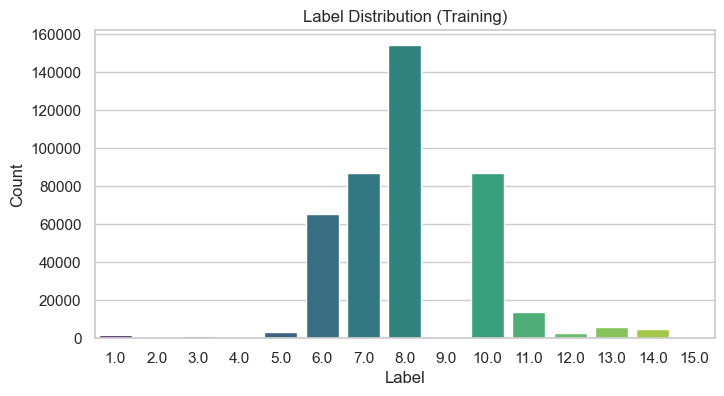

In [3]:
# Inspect columns
print("Train Data Columns:", train_data.columns.tolist())

# Describe the data
print("\nTrain Data Description:\n", train_data.describe())

# Label distribution
label_counts = train_data['label'].value_counts()
print("\nLabel Distribution (Train):\n", label_counts)

# Quick plot of label distribution
plt.figure(figsize=(8,4))
sns.countplot(data=train_data, x='label', palette='viridis')
plt.title('Label Distribution (Training)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We do the same quick check for the test dataset.

Test Data Columns: ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'label']

Test Data Description:
               band_1         band_2         band_3         band_4  \
count  194863.000000  194863.000000  194863.000000  194863.000000   
mean        0.069455       0.073421       0.084841       0.090647   
std         0.030469       0.033433       0.040003       0.055380   
min         0.017371       0.013128       0.007772       0.005486   
25%         0.054892       0.060166       0.059666       0.040884   
50%         0.072899       0.079150       0.096921       0.102498   
75%         0.078158       0.085946       0.111762       0.137225   
max         0.450591       0.467286       0.447950       0.483281   

              band_5         band_6         band_7         band_8  \
count  194863.000000  194863.000000  194863.000000  194863.000000   
mean        0.080503       0.064503       0.070929       0.058735   
std  

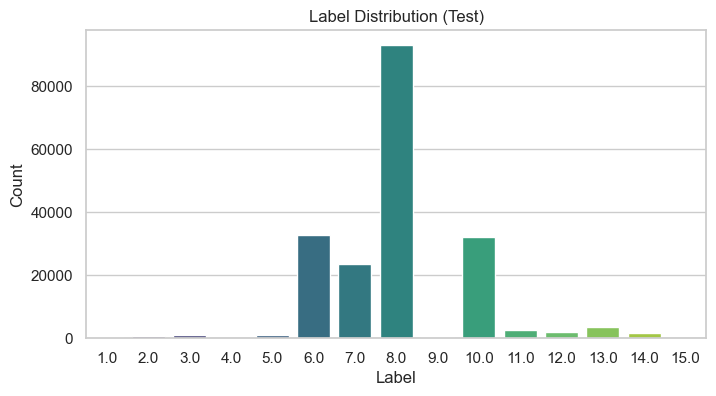

In [4]:
print("Test Data Columns:", test_data.columns.tolist())
print("\nTest Data Description:\n", test_data.describe())

# Label distribution in test set
label_counts_test = test_data['label'].value_counts()
print("\nLabel Distribution (Test):\n", label_counts_test)

plt.figure(figsize=(8,4))
sns.countplot(data=test_data, x='label', palette='viridis')
plt.title('Label Distribution (Test)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

<a id="split"></a>
## 4. Train/Test Split
The data is already conceptually split into training (`train_data`) and test (`test_data`). We separate features and labels.


In [5]:
# For the training set
X = train_data.drop('label', axis=1)
y = train_data['label']
print("Training features shape:", X.shape)

# For the test set
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']
print("Test features shape:", X_test.shape)

Training features shape: (429412, 11)
Test features shape: (194863, 11)


<a id="train"></a>
## 5. Train Random Forest
We train a basic Random Forest classifier with default parameters (except `n_jobs` and `random_state`).


In [6]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X, y)
print("Random Forest model trained.")

Random Forest model trained.


<a id="evaluate"></a>
## 6. Evaluate the Model
We use the test set for predictions, then show a classification report and confusion matrix.

Classification Report (Base RF):
               precision    recall  f1-score   support

         1.0       0.52      0.94      0.67       381
         2.0       0.94      0.92      0.93       760
         3.0       0.74      0.91      0.82       881
         4.0       0.44      0.49      0.46        49
         5.0       0.66      0.74      0.70      1174
         6.0       0.83      0.94      0.88     32843
         7.0       0.70      0.56      0.62     23443
         8.0       0.99      1.00      1.00     93037
         9.0       0.47      0.27      0.35       387
        10.0       0.94      0.83      0.88     32226
        11.0       0.17      0.33      0.22      2506
        12.0       0.20      0.07      0.10      1865
        13.0       0.41      0.46      0.43      3649
        14.0       0.06      0.12      0.08      1570
        15.0       0.02      0.11      0.04        92

    accuracy                           0.87    194863
   macro avg       0.54      0.58      0.55   

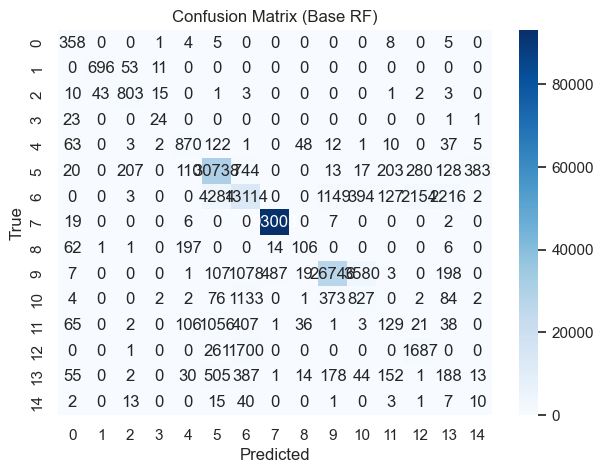

In [7]:
# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Classification report
print("Classification Report (Base RF):\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Base RF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id="tuning"></a>
## 7. Optional: Hyperparameter Tuning
We'll do a quick `GridSearchCV` to find better hyperparameters for the Random Forest. This part can be time-consuming.


In [8]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)

# Use the best estimator
rf_best = grid_search.best_estimator_
print("Optimized Random Forest trained.")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Optimized Random Forest trained.


### Evaluate the Optimized Model
We check how the model with best parameters performs on the test set.

Classification Report (Optimized RF):
               precision    recall  f1-score   support

         1.0       0.51      0.92      0.66       381
         2.0       0.95      0.91      0.93       760
         3.0       0.63      0.92      0.75       881
         4.0       0.42      0.47      0.44        49
         5.0       0.66      0.74      0.70      1174
         6.0       0.83      0.93      0.88     32843
         7.0       0.69      0.54      0.60     23443
         8.0       1.00      1.00      1.00     93037
         9.0       0.47      0.29      0.36       387
        10.0       0.94      0.79      0.86     32226
        11.0       0.12      0.32      0.18      2506
        12.0       0.19      0.07      0.10      1865
        13.0       0.40      0.46      0.43      3649
        14.0       0.06      0.13      0.08      1570
        15.0       0.02      0.10      0.04        92

    accuracy                           0.86    194863
   macro avg       0.53      0.57      0.

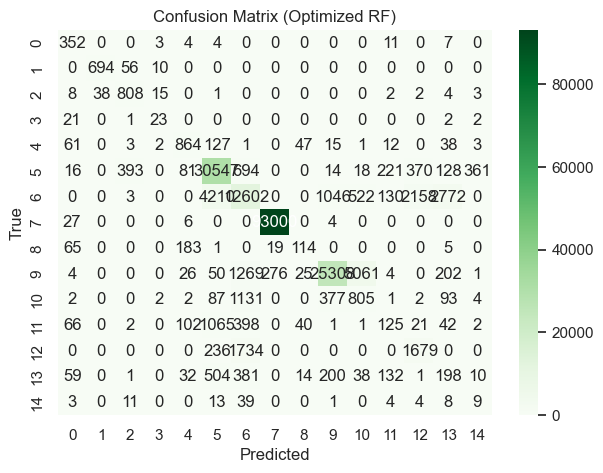

In [9]:
y_pred_best = rf_best.predict(X_test)

print("Classification Report (Optimized RF):\n", classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7,5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Optimized RF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<a id="crossval"></a>
## 8. Cross-Validation
We can verify the model's stability with cross-validation on the training data.


In [10]:
cv_scores = cross_val_score(rf_best, X, y, cv=5, scoring='f1_weighted', n_jobs=-1)
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1:", cv_scores.mean())

Cross-Validation F1 Scores: [0.73846048 0.93052283 0.87159656 0.84923861 0.71923   ]
Mean F1: 0.821809697422015


<a id="importance"></a>
## 9. Feature Importance
We can see which spectral bands or features matter most.


Feature Importances:
 band_3     0.158786
band_4     0.157905
band_10    0.116472
band_11    0.100236
band_5     0.098181
band_1     0.084275
band_2     0.064712
band_8     0.059790
band_7     0.059547
band_6     0.053429
band_9     0.046666
dtype: float64


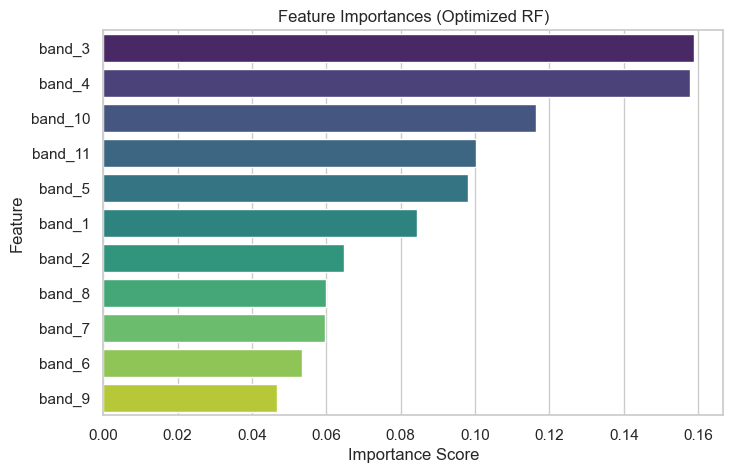

In [11]:
importances = rf_best.feature_importances_
features = X.columns

feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importances (Optimized RF)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

<a id="save"></a>
## 10. Save and Load Model
We can serialize the final model with `joblib`.

In [12]:
# Save the optimized model
joblib.dump(rf_best, model_best_save_path)
print(f"Optimized model saved to: {model_best_save_path}")

# Load the model (example usage)
loaded_model = joblib.load(model_best_save_path)
print("Loaded optimized RF model from file.")

Optimized model saved to: c:\Users\ronal\Documents\AI project\marine-debris.github.io\data\random_forest_model_optimized.pkl
Loaded optimized RF model from file.


<a id="conclusion"></a>
## 11. Conclusion

- We loaded MARIDA data from HDF5 files.
- We trained a Random Forest and performed basic evaluations.
- We optionally tuned hyperparameters via GridSearchCV.
- We examined cross-validation scores and feature importances.
- Finally, we saved the optimized model.

This completes the classification workflow on MARIDA.